This notebook is for analyzing absorption features in the KELT-9b_20180703_PEPSI dataset via cross correlation.

# Imports

In [2]:
import glob
import os
os.chdir('/home/paiasnodkar.1/AtmosphericDynamics/')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

import scipy.signal

import astropy.modeling
import astropy.units as u

import pandas as pd

import emcee
import corner
from multiprocessing import Pool

try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

import importlib
    
import TransmissionSpectroscopy_lib_unity as TSL
import PlanetModel_lib as PM

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

# Read in data

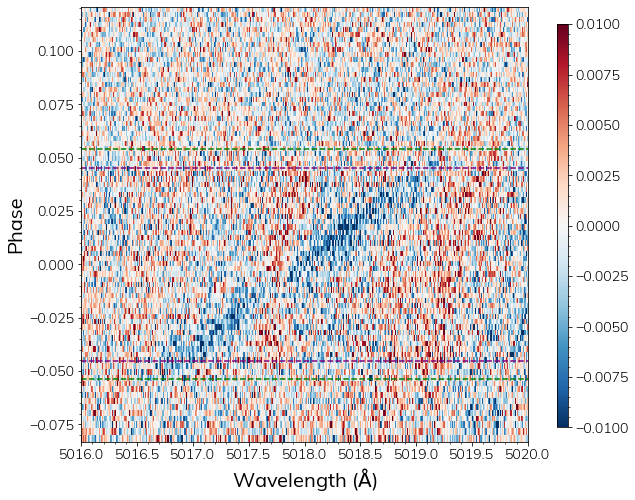

In [3]:
# Data set labels
planet_name = 'KELT-9b_20180703_PEPSI'
planet_name_ref = 'KELT-9b'
planet_config = 'planet_configs/'+planet_name_ref+'_config.txt'
petit_config = 'petitRADTRANS_configs/'+planet_name_ref+'_petitRADTRANS_config.txt'
v_sys_PEPSI = -17.86 * u.km/u.s

# Read in data and crop
with open('data/'+planet_name_ref+'/'+planet_name+'/'+planet_name+'_transmission.pkl', "rb") as input_file: # stellar or transmission
    FM = pickle.load(input_file)

# Plot
vrange = [-0.01, 0.01]
vel_range = [5016, 5020]

fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(FM.wav.value, FM.phaseFold().value, FM.fluxes, vmin=vrange[0], vmax=vrange[1], 
                   cmap='RdBu_r')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.xlim(vel_range[0], vel_range[1])
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel(r'Phase')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.png', dpi=300, bbox_inches='tight')
# plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.pdf')
plt.show()

# Make species template

Run petitRADTRANS model


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



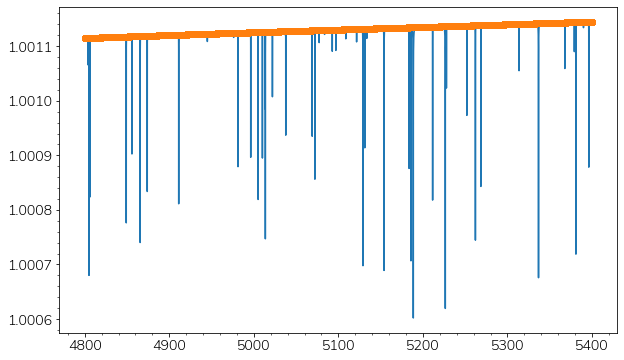

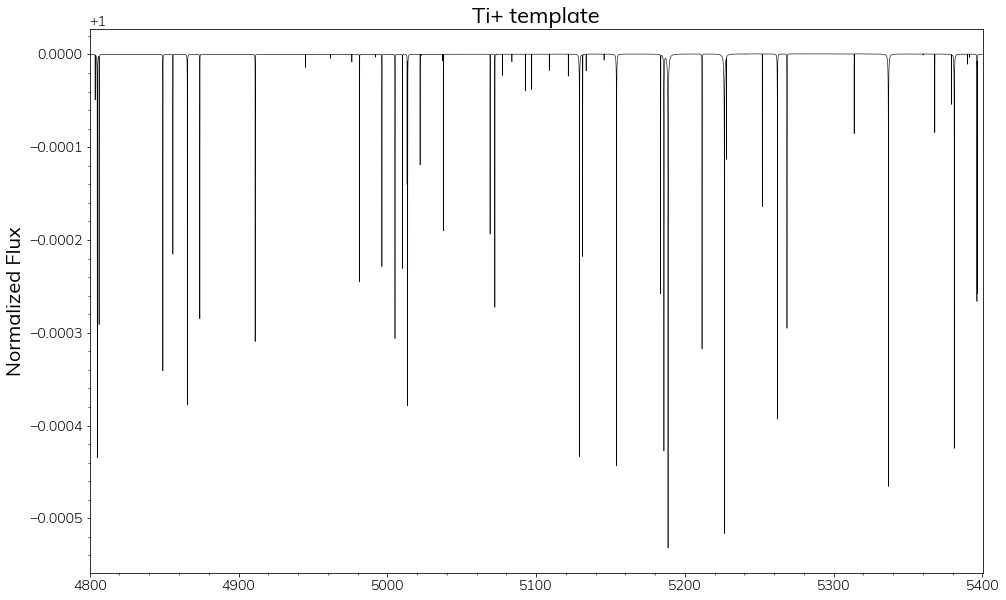

In [5]:
species = ['Ti+']
species_str = ' '.join(species)
lambda_low = 4800
lambda_up = 5400
pressures = np.logspace(-10, 2, 130)
contribution = False
Pcloud = False
in_air = True # True if Fe+, Ti+
normalize = True
cutoff = 0.9
exclude = None
smooth = 1e-2

if contribution:    
    wav_model, rad_model, flx_model, temperatures, contr_func = PM.make_transmission_template(planet_name_ref,
                            planet_config, petit_config, species, lambda_low, lambda_up, pressures, 
                            contribution=contribution, Pcloud=Pcloud, in_air=in_air, normalize=normalize, 
                            cutoff=cutoff, exclude=exclude, smooth=smooth)
else:
    wav_model, rad_model, flx_model, temperatures = PM.make_transmission_template(planet_name_ref,
                            planet_config, petit_config, species, lambda_low, lambda_up, pressures, 
                            contribution=contribution, Pcloud=Pcloud, in_air=in_air, normalize=normalize, 
                            cutoff=cutoff, exclude=exclude, smooth=smooth)
    
# Plot template
plt.figure(figsize=(16,10))
plt.plot(wav_model, flx_model, 'k', linewidth=0.6)
plt.xlim(min(wav_model), max(wav_model))
plt.ylabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux')
plt.title(species_str+' template')
plt.show()

Read in existing petitRADTRANS template and contribution function

In [46]:
species_str = 'Fe+'
lambda_low, lambda_up = 4800, 5400
template_dir = 'planet_templates/'+planet_name_ref+'/'
lambda_str = str(lambda_low)+'_'+str(lambda_up)
template_filename = template_dir+planet_name_ref+'_'+species_str+'_'+lambda_str+'_template.csv'
PT_filename = template_dir+planet_name_ref+'_'+species_str+'_'+lambda_str+'_PT.csv'
contr_func_filename = template_dir+planet_name_ref+'_'+species_str+'_'+lambda_str+'_contributionFunction.npy'

# Read in template
df = pd.read_csv(template_filename, comment='#')
wav_model, rad_model, flx_model = np.array(df['Wavelength']), np.array(df['Radius']), np.array(df['Flux'])

# Read in comments
with open(template_filename, 'r+') as f:
    data = f.readlines()

comment_str = ''
for line in data[1:]:
    if '#' in line:
        comment_str += line

# Read in P-T profile
df = pd.read_csv(PT_filename, comment='#')
pressures, temperatures = np.array(df['Pressure']), np.array(df['Temperature'])

# Read in contribution function
contr_func = np.load(contr_func_filename)

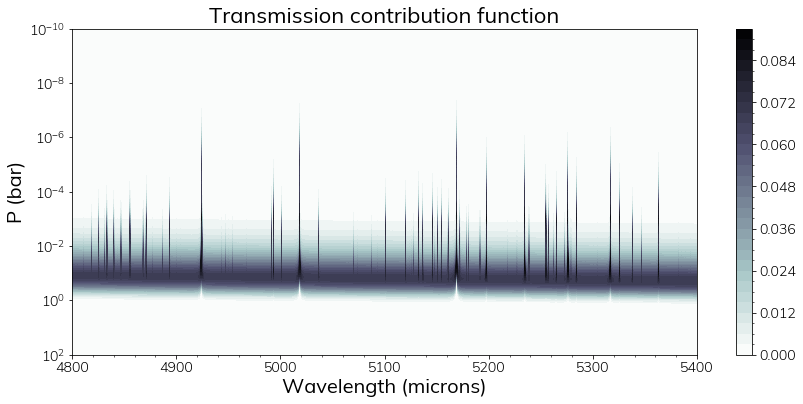

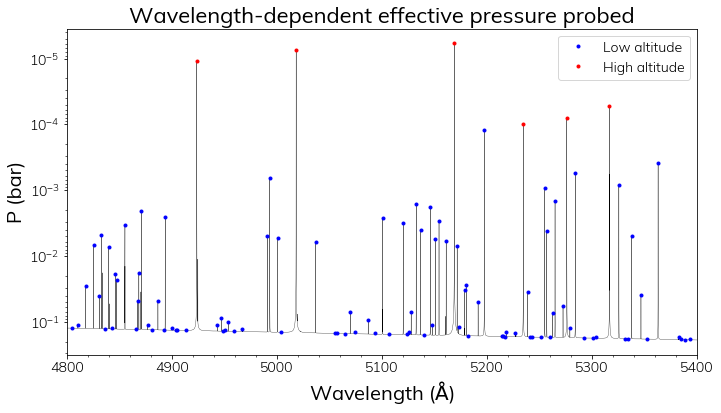

In [47]:
# Contribution function
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.contourf(wav_model, pressures, contr_func, 30,cmap=plt.cm.bone_r)
plt.xlim(min(wav_model), max(wav_model))
plt.yscale('log')
ax.invert_yaxis()
plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Transmission contribution function')
plt.colorbar()
plt.show()

# Identify lines
pressure_threshold = 5 # percentile of high altitude lines
order = 200 # how many points on each side for comparison to find relative minima
pressure_eff, line_indices, high_alt = PM.find_lines(pressures, contr_func, pressure_threshold, order)
low_alt = ~high_alt

fig, ax = plt.subplots(1, 1, figsize=(11.3, 6))
plt.plot(wav_model, pressure_eff, 'k', linewidth=0.3)
plt.plot(wav_model[line_indices][low_alt], pressure_eff[line_indices][low_alt], 'b.', label='Low altitude')
plt.plot(wav_model[line_indices][high_alt], pressure_eff[line_indices][high_alt], 'r.', label='High altitude')
plt.xlim(min(wav_model), max(wav_model))
plt.yscale('log')
ax.invert_yaxis()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('P (bar)')
plt.title('Wavelength-dependent effective pressure probed')
plt.legend(fontsize=14)
plt.show()

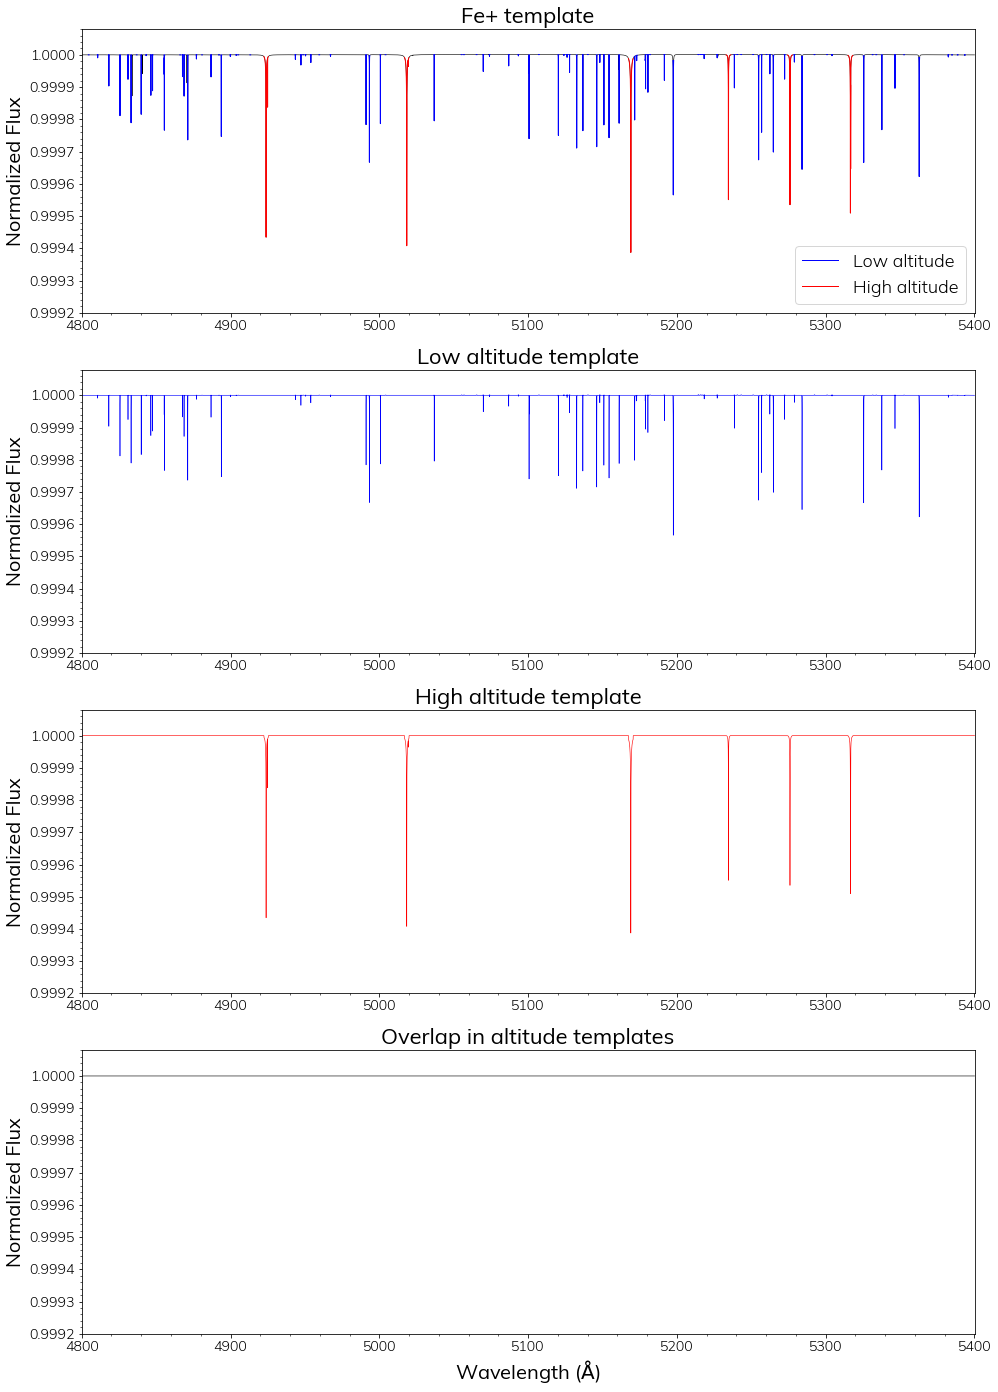

# planet_templates/KELT-9b/KELT-9b_Fe+_4800_5400_low_template.csv
# 
# Parameters 
# M_p: 5466614399999999688230203031552.000000 g 
# R_p: 13519137200.000000 cm 
# R_star: 164277100000.000000 cm 
# gravity: 1996.164283 cm/s^2 
# MMW: 2.330000 
# P_0: 0.000000 bars 
# P_low: 0.000000 bars 
# P_up: 100.000000 bars 
# kappa_IR: 1.000000 
# gamma: 0.400000 
# T_int: 100.000000 K 
# T_eq: 4050.000000 K 
# P_low: 0.000000 bars 
# P_up: 100.000000 bars 
# H2 mass fraction: 0.856287 
# He mass fraction: 0.142997 
# Fe+ mass fraction: 0.000716 
Wavelength,Radius,Flux

# planet_templates/KELT-9b/KELT-9b_Fe+_4800_5400_high_template.csv
# 
# Parameters 
# M_p: 5466614399999999688230203031552.000000 g 
# R_p: 13519137200.000000 cm 
# R_star: 164277100000.000000 cm 
# gravity: 1996.164283 cm/s^2 
# MMW: 2.330000 
# P_0: 0.000000 bars 
# P_low: 0.000000 bars 
# P_up: 100.000000 bars 
# kappa_IR: 1.000000 
# gamma: 0.400000 
# T_int: 100.000000 K 
# T_eq: 4050.000000 K 
# P_low: 0.000000 bars 
# P_up:

In [55]:
# Make low altitude template
low_width = 50
low_lines, low_lines_list = PM.make_altitude_mask(line_indices[low_alt], low_width, len(wav_model))
flx_model_low, rad_model_low = PM.make_altitude_temp(flx_model, rad_model, low_lines, FM.R_p[0])

# Make high altitude template
high_width = 300
high_lines, high_lines_list = PM.make_altitude_mask(line_indices[high_alt], high_width, len(wav_model))
flx_model_high, rad_model_high = PM.make_altitude_temp(flx_model, rad_model, high_lines, FM.R_p[0])

# Make overlap template
overlap_lines = np.intersect1d(low_lines, high_lines)
flx_model_overlap = np.ones_like(flx_model)
flx_model_overlap[overlap_lines] = flx_model[overlap_lines]

ymin, ymax = 0.9992, 1.00008

fig, ax = plt.subplots(4, 1, figsize=(16,24))

# Plot template and identify lines of different altitudes
ax[0].plot(wav_model, flx_model, 'k', linewidth=0.6)
# Plot low altitude lines
linewidth = 1
for low_line in low_lines_list[:-1]:
    ax[0].plot(wav_model[low_line], flx_model[low_line], 'b-', linewidth=linewidth)
ax[0].plot(wav_model[low_lines_list[-1]], flx_model[low_lines_list[-1]], 'b-', linewidth=linewidth, label='Low altitude')
# Plot high altitude lines
for high_line in high_lines_list[:-1]:
    ax[0].plot(wav_model[high_line], flx_model[high_line], 'r-', linewidth=linewidth)
ax[0].plot(wav_model[high_lines_list[-1]], flx_model[high_lines_list[-1]], 'r-', linewidth=linewidth, label='High altitude')
ax[0].set_xlim(min(wav_model), max(wav_model))
ax[0].set_ylim(ymin, ymax)
ax[0].legend(fontsize=18, loc='lower right')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_title(species_str+' template')

# Plot low altitude template
ax[1].plot(wav_model, flx_model_low, 'b-', linewidth=0.6)
ax[1].set_xlim(min(wav_model), max(wav_model))
ax[1].set_ylim(ymin, ymax)
ax[1].set_title('Low altitude template')
ax[1].set_ylabel('Normalized Flux')

# Plot low altitude template
ax[2].plot(wav_model, flx_model_high, 'r-', linewidth=0.6)
ax[2].set_xlim(min(wav_model), max(wav_model))
ax[2].set_ylim(ymin, ymax)
ax[2].set_ylabel('Normalized Flux')
ax[2].set_title('High altitude template')

# Plot overlap in templates
ax[3].plot(wav_model, flx_model_overlap, 'k', linewidth=0.6)
ax[3].set_xlim(min(wav_model), max(wav_model))
ax[3].set_ylim(ymin, ymax)
ax[3].set_title('Overlap in altitude templates')
ax[3].set_ylabel('Normalized Flux')
ax[3].set_xlabel(r'Wavelength ($\mathrm{\AA}$)')

plt.savefig('figs/templates/'+planet_name_ref+'_'+species_str+lambda_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

# Save low altitude template spectrum
template_filename = template_dir+planet_name_ref+'_'+species_str+'_'+lambda_str+'_low_template.csv'
header_str_template = '# '+template_filename+'\n' + comment_str + 'Wavelength,Radius,Flux\n'
print(header_str_template)
df = pd.DataFrame(np.vstack([wav_model, rad_model_low, flx_model_low]).T)
df.head()
with open(template_filename, 'w') as f:# Append
    f.write(header_str_template)
    df.to_csv(f, mode='w', header=False, index=False)
    f.close()
    
# Save high altitude template spectrum
template_filename = template_dir+planet_name_ref+'_'+species_str+'_'+lambda_str+'_high_template.csv'
header_str_template = '# '+template_filename+'\n' + comment_str + 'Wavelength,Radius,Flux\n'
print(header_str_template)
df = pd.DataFrame(np.vstack([wav_model, rad_model_low, flx_model_low]).T)
df.head()
with open(template_filename, 'w') as f:# Append
    f.write(header_str_template)
    df.to_csv(f, mode='w', header=False, index=False)
    f.close()

# Cross-correlate

Full template

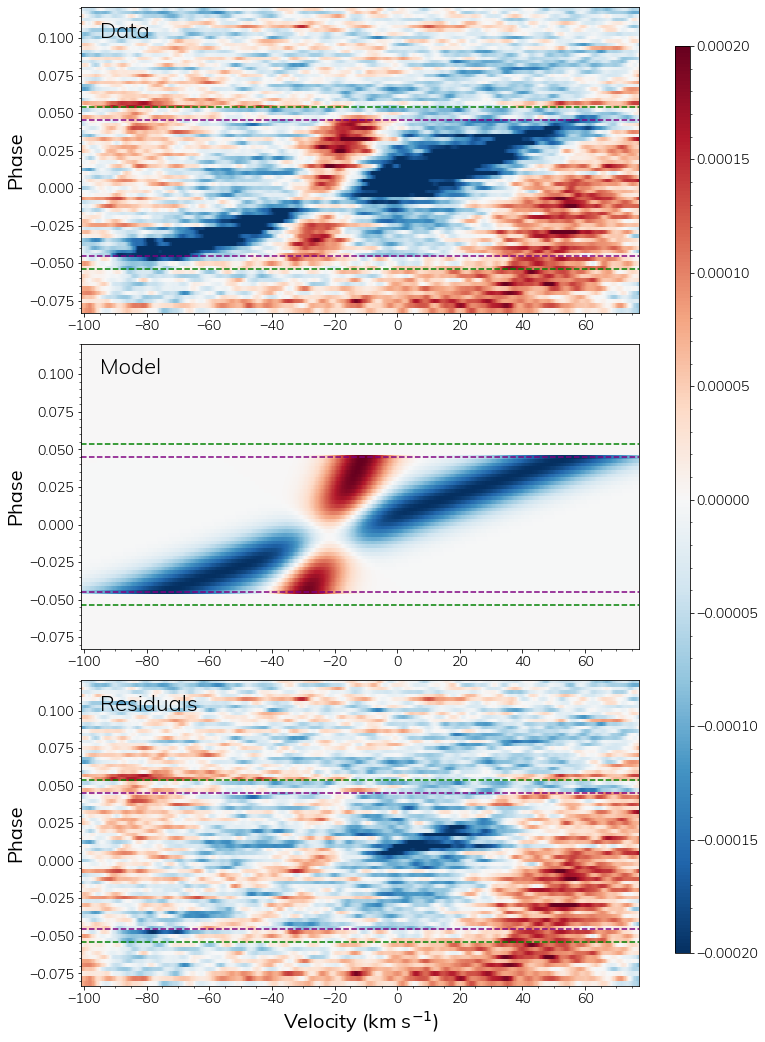

In [59]:
index_shift_low, index_shift_up = 300,150
flx_model_interp = TSL.interpolate_xy(wav_model, flx_model, FM.wav)
vels, CCFs, CCFs_err = TSL.FluxMap.cross_corr(FM.wav, FM.fluxes, FM.fluxes_err, flx_model_interp-1, 
                                      index_shift_low, index_shift_up)
CCFs *= -1

# Shift for systemic velocity
vels = vels - v_sys_PEPSI

theta = [232, -10, 2e-4, 17, 200, -20, 2e-4, 7]

model_transit = TSL.model_planet_transit(theta, vels.value, FM.phaseFold()[FM.isIn()].value)
model = np.zeros_like(CCFs)
model[FM.isIn()] = model_transit

vrange = [-2e-4, 2e-4]
fig, ax = plt.subplots(3, 1, figsize=(10,18))
plt.subplots_adjust(hspace=0.1)
# Data
im = ax[0].pcolormesh(vels.value, FM.phaseFold().value, CCFs, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].set_ylabel(r'Phase')
ax[0].text(-95, 0.1, r'Data', fontsize=22)

# Model
im = ax[1].pcolormesh(vels.value, FM.phaseFold().value, model, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].set_ylabel(r'Phase')
ax[1].text(-95, 0.1, r'Model', fontsize=22)

# Residuals
im = ax[2].pcolormesh(vels.value, FM.phaseFold().value, CCFs - model, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].set_xlabel(r'Velocity (km s$^{-1}$)')
ax[2].set_ylabel(r'Phase')
ax[2].text(-95, 0.1, r'Residuals', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [ ]:
theta = [232, -10, 2e-4, 17, 200, -20, 2e-4, 7]

priors = np.array([[100, 500], 
                   [-50, 0], 
                   [0, 1], 
                   [1, 50],
                   [100, 500],
                   [-50, 0],
                   [0, 1],
                   [1, 50]])
priors_bool = np.array([True]*len(priors))

phases_in = FM.phaseFold().value[FM.isIn()]
CCFs_in = CCFs[FM.isIn()]
CCFs_err_in = CCFs_err[FM.isIn()]

pos = theta + 1e-4 * np.random.randn(100, len(theta))
nwalkers, ndim = pos.shape
# backend = emcee.backends.HDFBackend('MCMC/'+planet_name+'/'+planet_name+'_injection_MCMC_'+suffix+'.h5')
# backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, TSL.logPosterior, 
                                    args=(priors, priors_bool, vels.value, CCFs_in, CCFs_err_in, 
                                          model_planet_transit, phases_in), pool=pool)
    max_n = 50000

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

# Plot distributions and fit
discard = 1000
np.set_printoptions(suppress=True)
lnprob = sampler.get_log_prob(discard=discard)
lnprob_flat = sampler.get_log_prob(discard=discard, flat=True)
chain = sampler.get_chain(discard=discard) #discard=1000
chain_flat = sampler.get_chain(discard=discard, flat=True)
theta_best = np.percentile(chain_flat, 50, axis=0)
print('Best: ', theta_best)

CCFs_model = TSL.model_planet_transit(theta_best, vels.value, phases_in)

labels = [r'$K_p$', r'$v_{\rm{offset}}$', r'$\delta$', r'$\sigma$',
              'shadow \n slope', 'shadow \n offset', 'shadow \n amplitude', 'shadow \n width']
fig = corner.corner(chain_flat, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 15}, title_fmt='.4f', label_kwargs={"fontsize": 16})

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)
plt.show()

vrange=[-2e-4, 2e-4]
fig,ax = plt.subplots(3,1, figsize=(8,12))
im = ax[0].pcolormesh(vels.value, phases_in, CCFs_in, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
ax[1].pcolormesh(vels.value, phases_in, CCFs_model, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
ax[2].pcolormesh(vels.value, phases_in, CCFs_in-CCFs_model, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
plt.xlabel('Velocity (km/s)')
fig.text(0.00, 0.5, 'Phase', va='center', rotation='vertical', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

High altitude

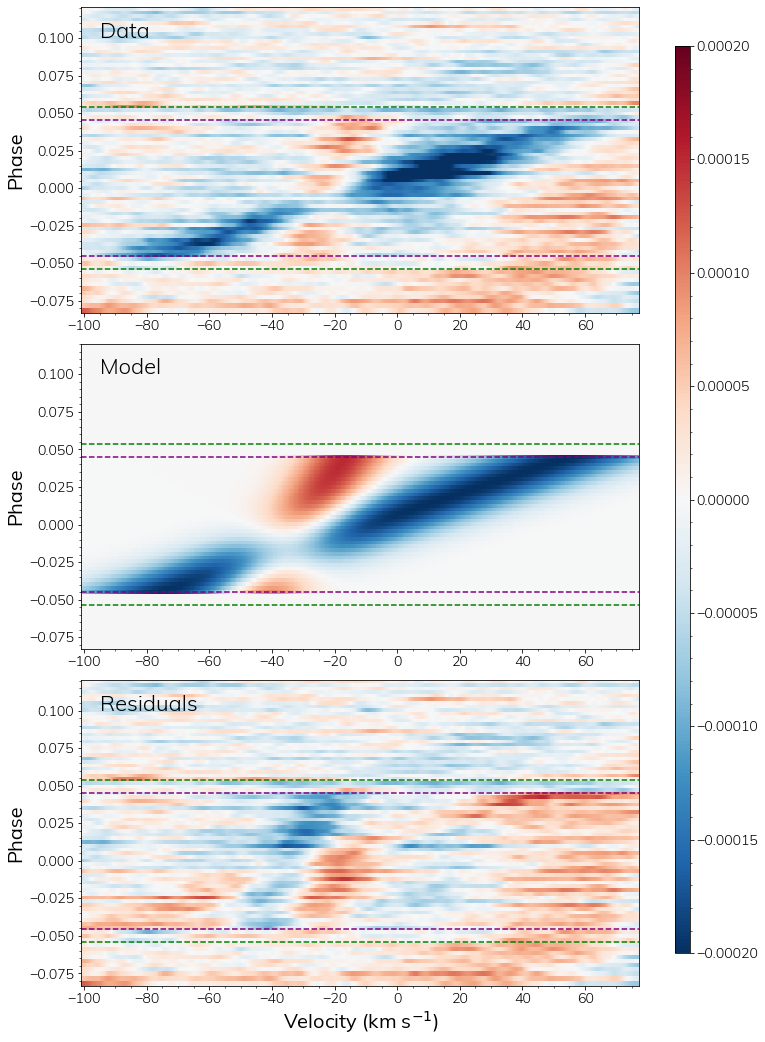

In [54]:
index_shift_low, index_shift_up = 300,150
flx_model_interp = TSL.interpolate_xy(wav_model, flx_model_high, FM.wav)
vels, CCFs, CCFs_err = TSL.FluxMap.cross_corr(FM.wav, FM.fluxes, FM.fluxes_err, flx_model_interp-1, 
                                      index_shift_low, index_shift_up)
CCFs *= -1

# Shift for systemic velocity
vels = vels - v_sys_PEPSI

theta = [232, -10, 2e-4, 17, 200, -20, 2e-4, 7]

model_transit = TSL.model_planet_transit(theta, vels.value, FM.phaseFold()[FM.isIn()].value)
model = np.zeros_like(CCFs)
model[FM.isIn()] = model_transit

vrange = [-2e-4, 2e-4]
fig, ax = plt.subplots(3, 1, figsize=(10,18))
plt.subplots_adjust(hspace=0.1)
# Data
im = ax[0].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].set_ylabel(r'Phase')
ax[0].text(-95, 0.1, r'Data', fontsize=22)

# Model
im = ax[1].pcolormesh(vels_corr.value, FM.phaseFold().value, model, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].set_ylabel(r'Phase')
ax[1].text(-95, 0.1, r'Model', fontsize=22)

# Residuals
im = ax[2].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs - model, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].set_xlabel(r'Velocity (km s$^{-1}$)')
ax[2].set_ylabel(r'Phase')
ax[2].text(-95, 0.1, r'Residuals', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Low altitude

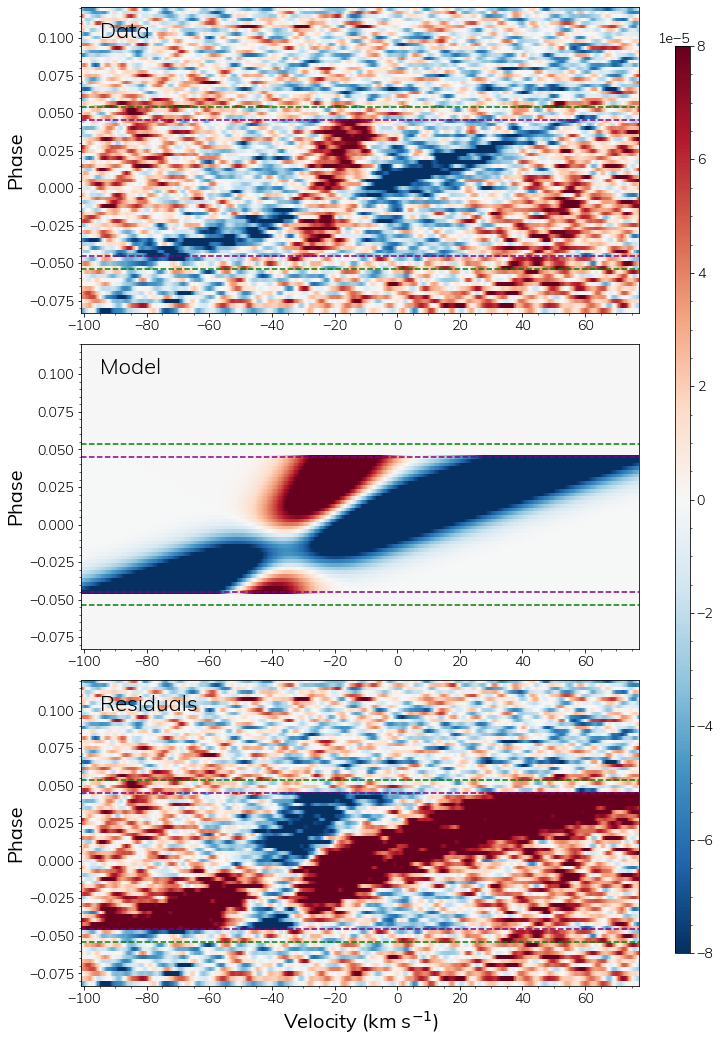

In [55]:
index_shift_low, index_shift_up = 300,150
flx_model_interp = TSL.interpolate_xy(wav_model, flx_model_low, FM.wav)
vels, CCFs, CCFs_err = TSL.FluxMap.cross_corr(FM.wav, FM.fluxes, FM.fluxes_err, flx_model_interp-1, 
                                      index_shift_low, index_shift_up)
CCFs *= -1

# Shift for systemic velocity
vels = vels - v_sys_PEPSI

theta = [232, -10, 2e-4, 17, 200, -20, 2e-4, 7]

model_transit = TSL.model_planet_transit(theta, vels.value, FM.phaseFold()[FM.isIn()].value)
model = np.zeros_like(CCFs)
model[FM.isIn()] = model_transit

vrange = [-0.8e-4, 0.8e-4]
fig, ax = plt.subplots(3, 1, figsize=(10,18))
plt.subplots_adjust(hspace=0.1)
# Data
im = ax[0].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].set_ylabel(r'Phase')
ax[0].text(-95, 0.1, r'Data', fontsize=22)

# Model
im = ax[1].pcolormesh(vels_corr.value, FM.phaseFold().value, model, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].set_ylabel(r'Phase')
ax[1].text(-95, 0.1, r'Model', fontsize=22)

# Residuals
im = ax[2].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs - model, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].set_xlabel(r'Velocity (km s$^{-1}$)')
ax[2].set_ylabel(r'Phase')
ax[2].text(-95, 0.1, r'Residuals', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

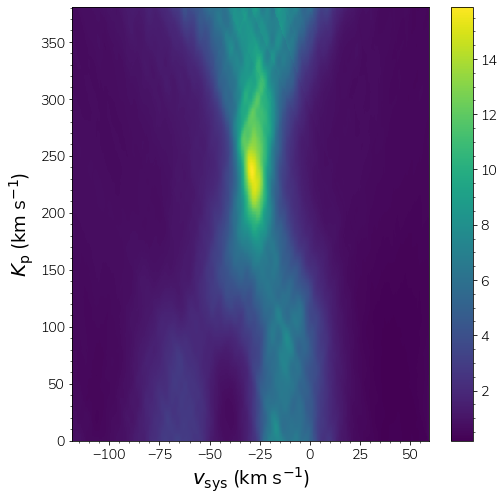

In [524]:
from astropy.modeling import models, fitting

v_rot = (2 * np.pi * FM.R_p[0])/FM.P[0]
v_rot = v_rot.to(u.km/u.s)
num_vels, num_K_pl = len(vels), 300
a_p = 0.03462 * u.AU
K_star = TSL.RV_semiAmplitude(FM.M_star[0], FM.M_p[0], a_p, 0, FM.i_p[0])
K_pl = K_star * FM.M_star[0].to(u.kg)/FM.M_p[0].to(u.kg)
K_pl_arr = np.linspace(0*(u.km/u.s), 1.5*K_pl.to(u.km/u.s), num_K_pl)

SNRs = np.ones((num_K_pl, num_vels)) * np.nan
for row, K_pl_test in enumerate(K_pl_arr):
    planet_vels = TSL.RV_circular_orbit(FM.phaseFold()[FM.isIn()].value, K_pl_test, 0).to(u.km/u.s)
    CCFs_shifted = np.array([TSL.interpolate_xy(vels-planet_vels[i], CCFs_corr[FM.isIn()][i], vels, 
                                                  fill_value=0) for i in range(len(CCFs_corr[FM.isIn()]))])
    CCF_stacked = np.sum(CCFs_shifted, axis=0)
    noise_arr = CCF_stacked[abs(vels)>1.5*v_rot]
    noise = np.std(noise_arr)
    SNRs[row,:] = CCF_stacked/noise 

SNRs -= np.median(SNRs)
where_plot = abs(vels) < 150 * u.km/u.s

# vrange = [0, 3]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels[where_plot].value, abs(K_pl_arr.value), np.exp(SNRs[:,where_plot]))#, 
#                    vmin=vrange[0], vmax=vrange[1])
# im = ax.pcolormesh(vels[where_plot].value, abs(K_pl_arr.value), SNRs[:,where_plot])#, 
#                    vmin=vrange[0], vmax=vrange[1])
plt.xlabel(r'$v_{\mathrm{sys}}$ (km s$^{-1}$)')
plt.ylabel('$K_{\mathrm{p}}$ (km s$^{-1}$)')
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im)#, cax=cbar_ax)
plt.show() 

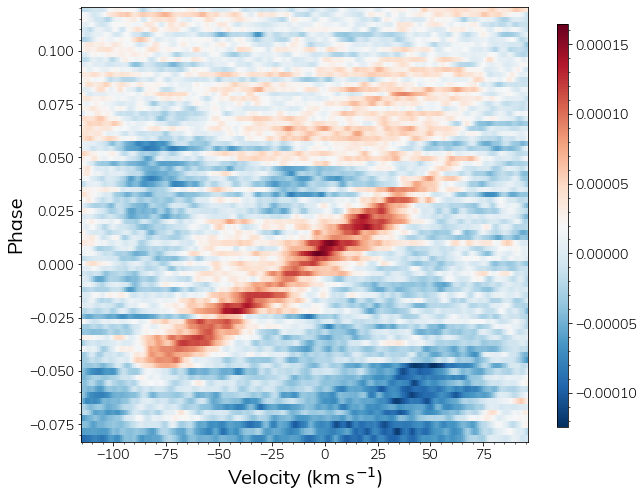

In [511]:
chain_flat = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_chain_CCF_GP_Fe+.npy')
theta_best = np.percentile(chain_flat, 50, axis=0)
phases = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_phases_CCF_Fe+.npy')
vels = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_vels_CCF_Fe+.npy')
CCFs = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_data_CCF_Fe+.npy')
CCFs_shadow = SME_interp_planet_rad_CCF(theta_best[0], FM.isIn(), vels, FM.phaseFold(), 'KELT-9b', 
                                         species_str)
CCFs_corr = CCFs-1-CCFs_shadow

# Plot
vrange = [-3e-4, 3e-4]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels, phases, CCFs-1-CCFs_shadow, cmap='RdBu_r')#, vmin=vrange[0], vmax=vrange[1])
# plt.axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
# plt.axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
# plt.axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
# plt.axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.xlabel(r'Velocity (km s$^{-1}$)')
plt.ylabel(r'Phase')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.png', dpi=300, bbox_inches='tight')
plt.show()

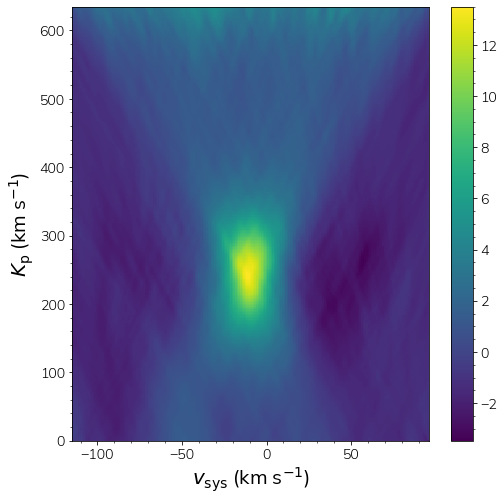

In [512]:
from astropy.modeling import models, fitting

v_rot = (2 * np.pi * FM.R_p[0])/FM.P[0]
v_rot = v_rot.to(u.km/u.s)
num_vels, num_K_pl = len(vels), 300
a_p = 0.03462 * u.AU
K_star = TSL.RV_semiAmplitude(FM.M_star[0], FM.M_p[0], a_p, 0, FM.i_p[0])
K_pl = K_star * FM.M_star[0].to(u.kg)/FM.M_p[0].to(u.kg)
K_pl_arr = np.linspace(0*(u.km/u.s), 2.5*K_pl.to(u.km/u.s), num_K_pl)

SNRs = np.ones((num_K_pl, num_vels)) * np.nan
for row, K_pl_test in enumerate(K_pl_arr):
    planet_vels = TSL.RV_circular_orbit(FM.phaseFold()[FM.isIn()].value, K_pl_test, 0).to(u.km/u.s)
    CCFs_shifted = np.array([TSL.interpolate_xy(vels-planet_vels[i].value, CCFs_corr[FM.isIn()][i], vels, 
                                                  fill_value=0) for i in range(len(CCFs[FM.isIn()]))])
    CCF_stacked = np.sum(CCFs_shifted, axis=0)
    noise_arr = CCF_stacked[abs(vels)>5*v_rot.value]
    noise = np.std(noise_arr)
    SNRs[row,:] = CCF_stacked/noise 

SNRs -= np.median(SNRs)
where_plot = abs(vels) < 150# * u.km/u.s

vrange = [-3, 5]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels[where_plot], abs(K_pl_arr.value), SNRs[:,where_plot])#, 
#                    vmin=vrange[0], vmax=vrange[1])
plt.xlabel(r'$v_{\mathrm{sys}}$ (km s$^{-1}$)')
plt.ylabel('$K_{\mathrm{p}}$ (km s$^{-1}$)')
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im)#, cax=cbar_ax)
plt.show() 

# Plot MCMC outputs

Temp type:  
Best:  [ 2.21101300e+02 -9.79600692e+00  2.47593464e-04  1.70184617e+01
  1.96210541e+02 -2.22186556e+01  2.02070302e-04  6.82093832e+00]


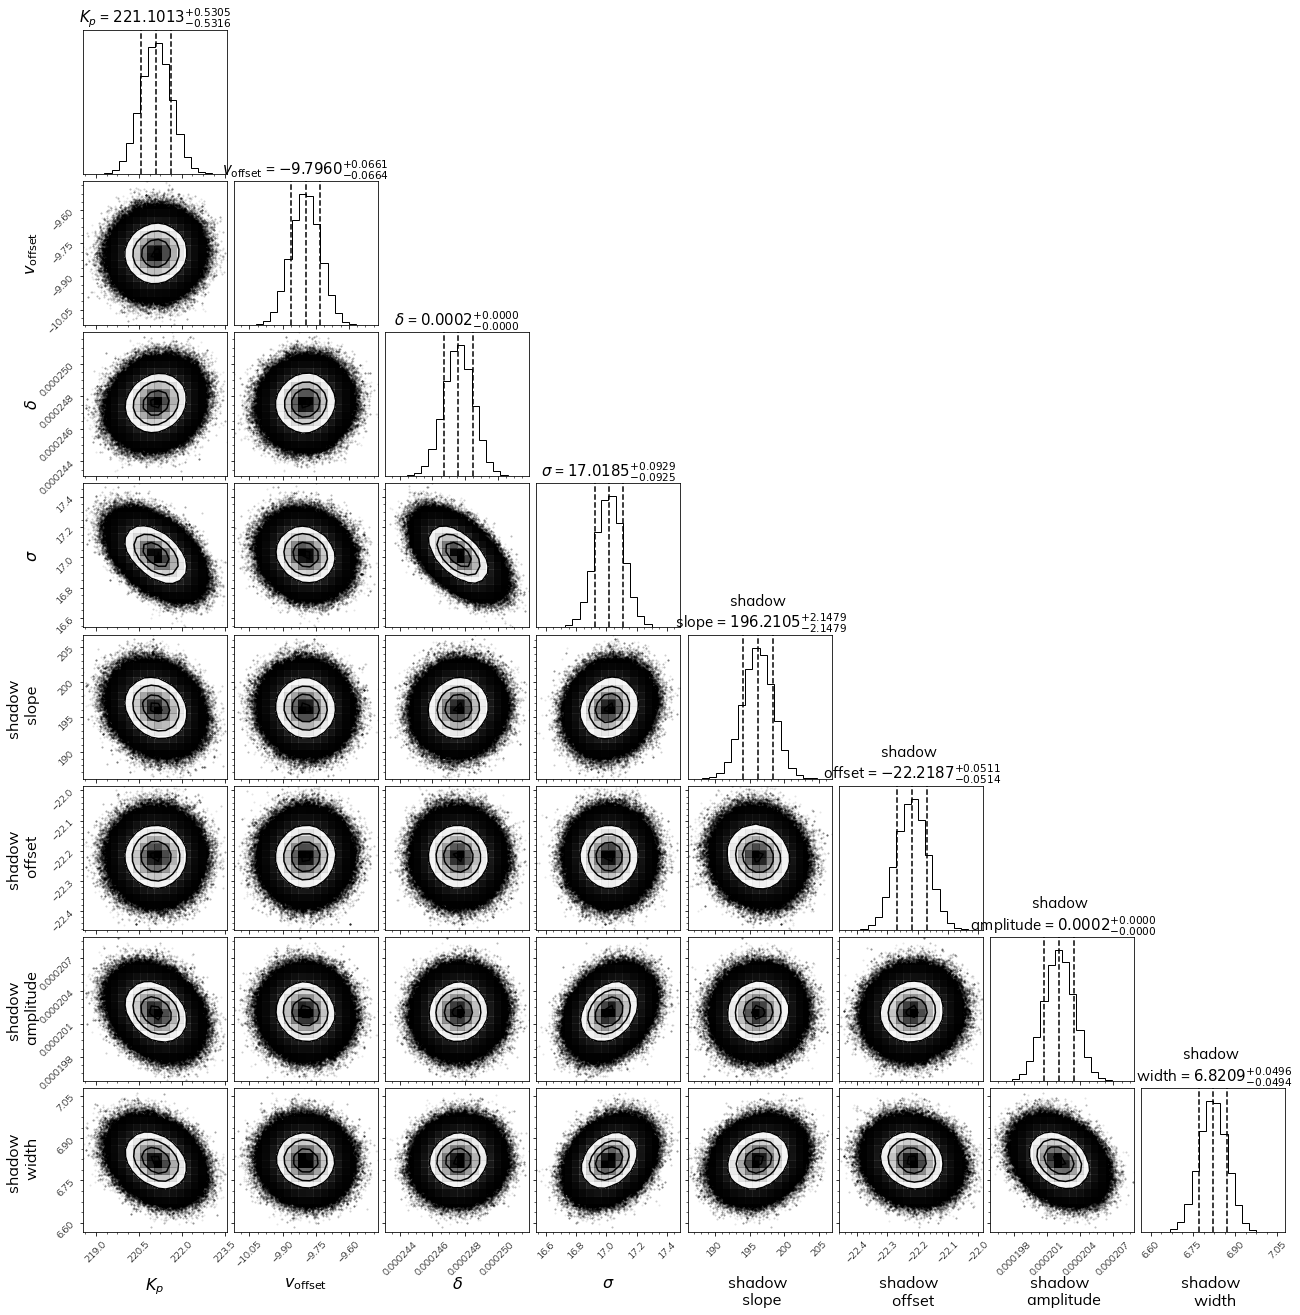

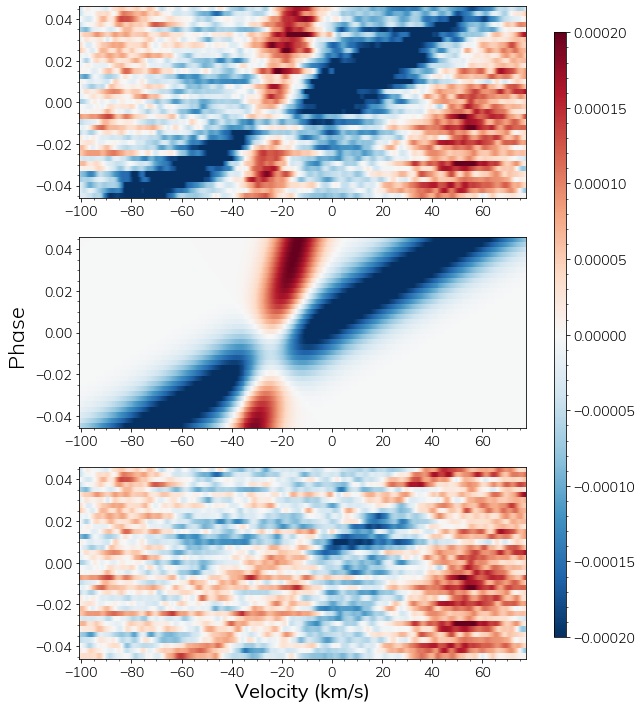

Temp type:  _low
Best:  [ 2.25818420e+02 -9.75146236e+00  7.07740146e-05  1.06846382e+01
  1.55266989e+02 -2.13590627e+01  8.14030031e-05  5.40215906e+00]


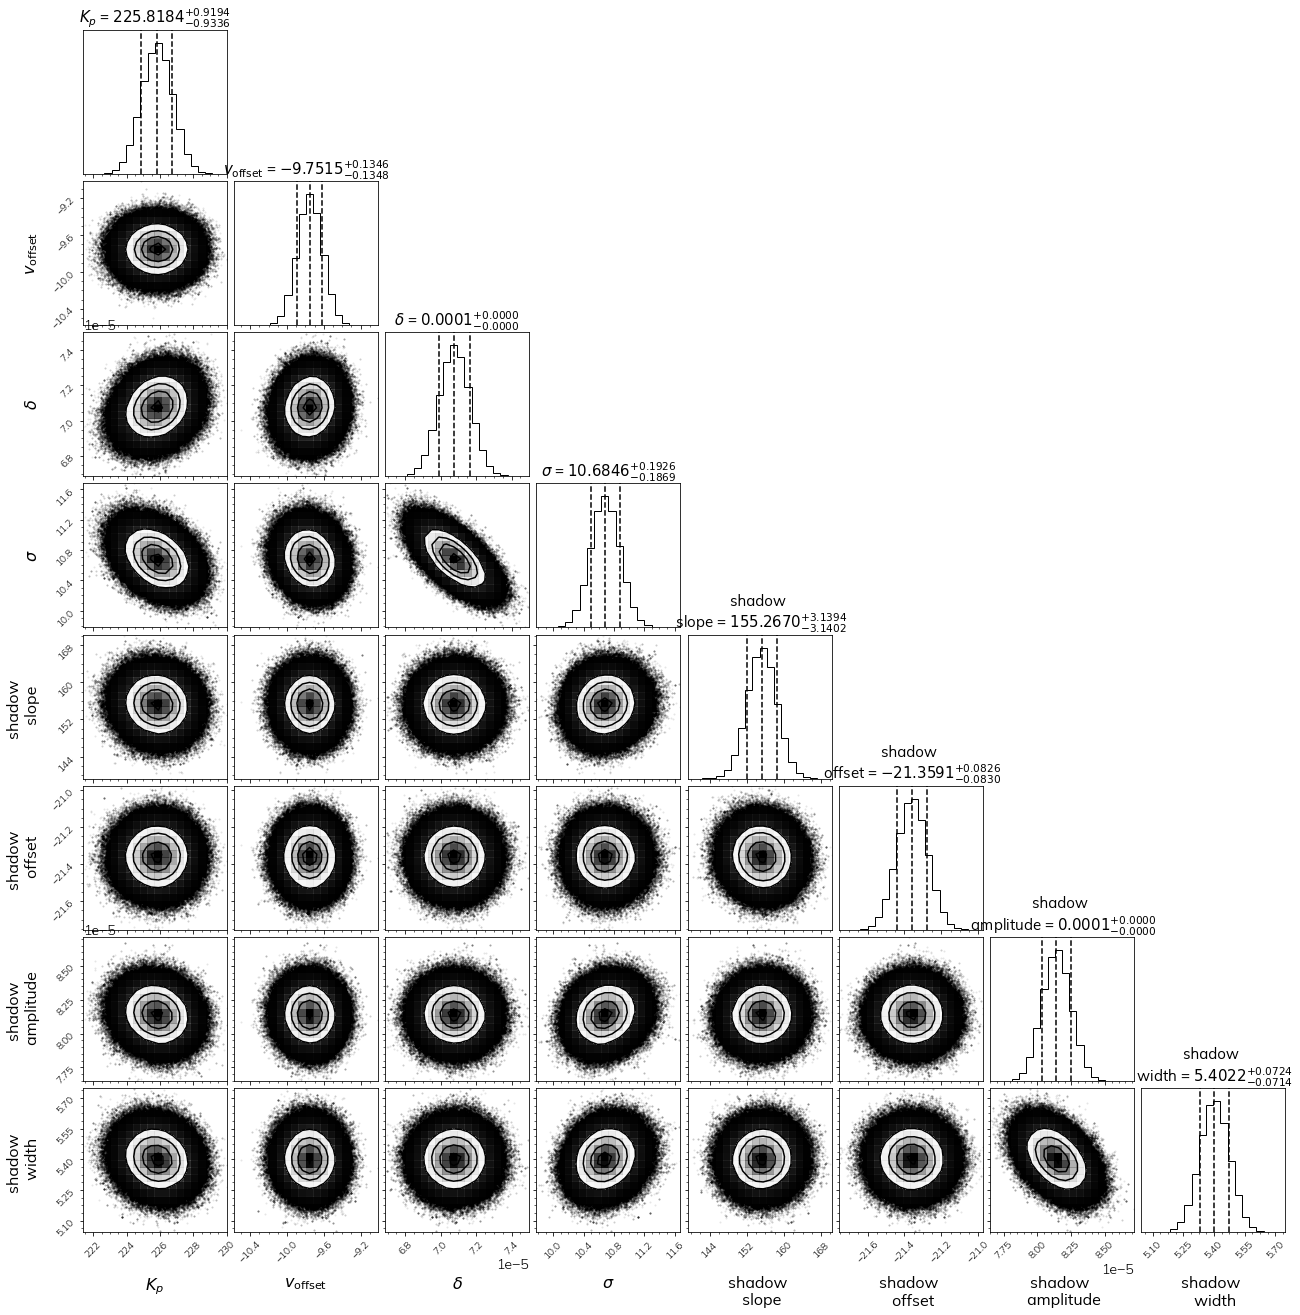

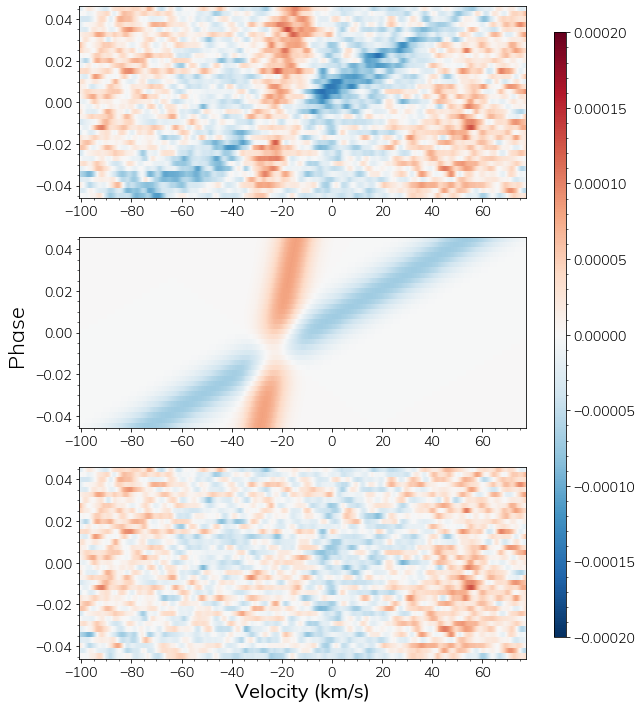

Temp type:  _high
Best:  [ 2.25825253e+02 -9.75089633e+00  7.07790257e-05  1.06876096e+01
  1.55269991e+02 -2.13599701e+01  8.13908362e-05  5.40347205e+00]


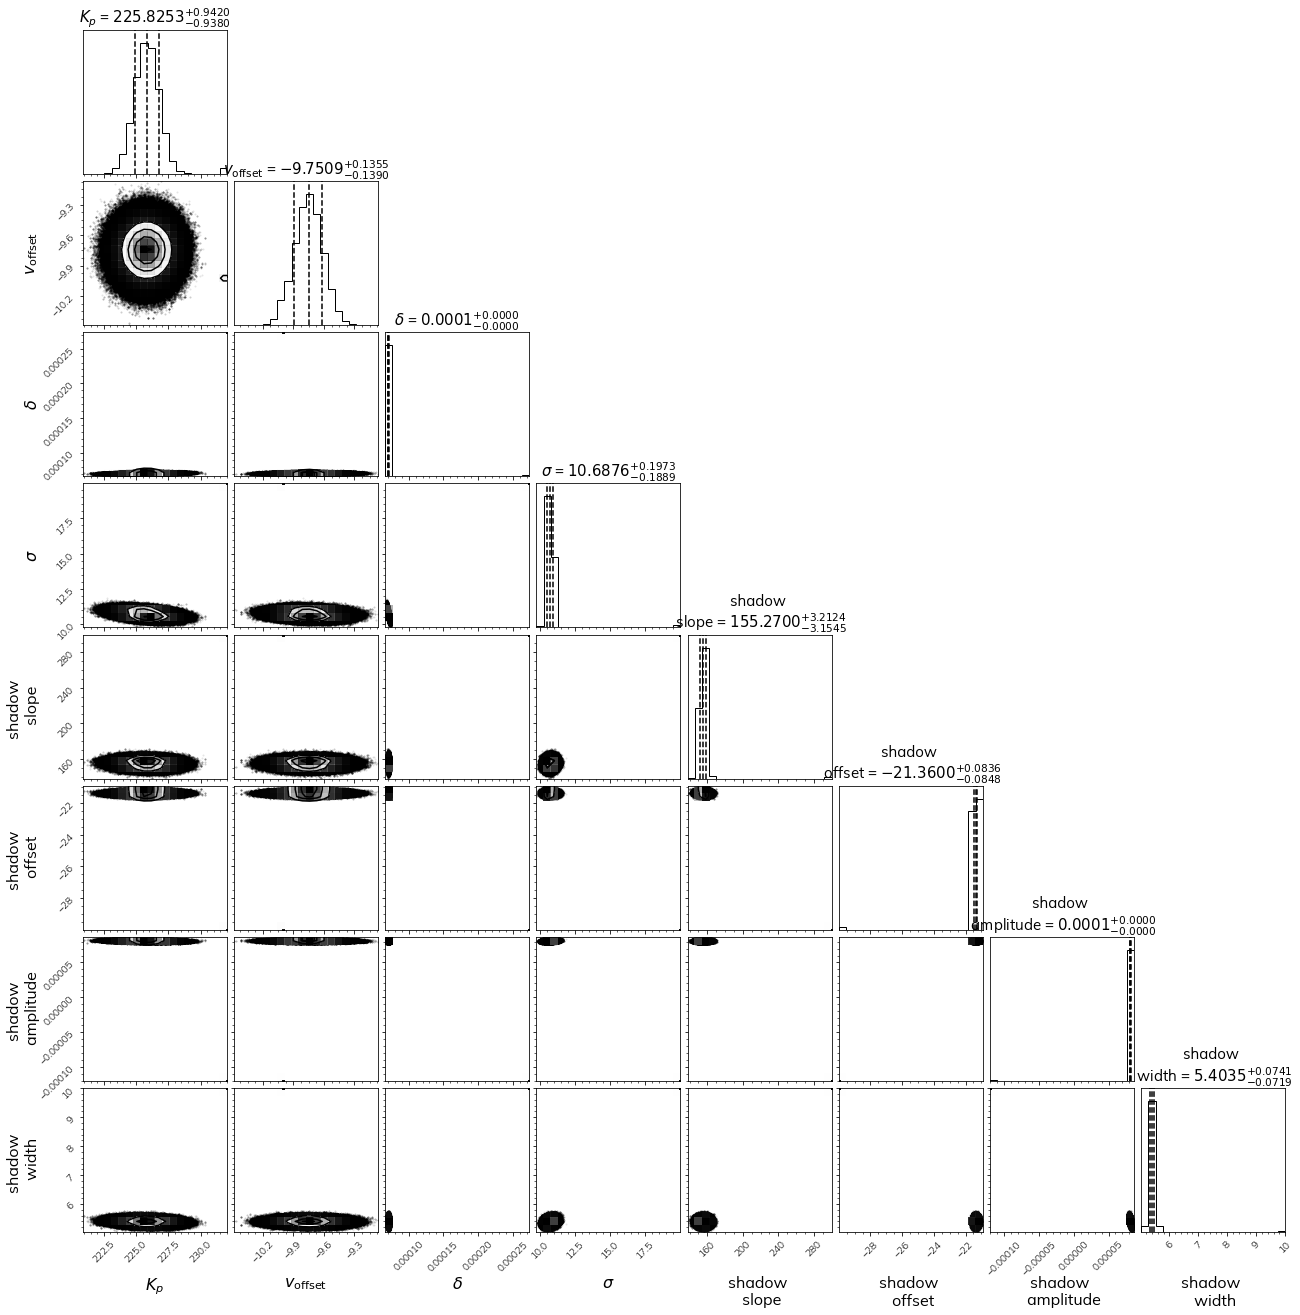

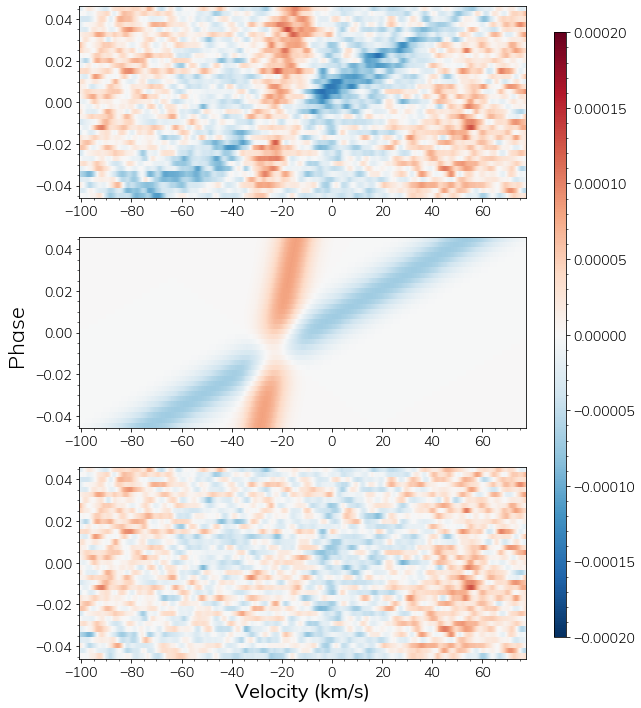

In [62]:
temp_types = ['', '_low', '_high']

for temp_type in temp_types:
    print('Temp type: ', temp_type)
    species_str = 'Fe+'
    chain_flat = np.load('MCMC/KELT-9b/KELT-9b_20180703_PEPSI/KELT-9b_20180703_PEPSI_chain_'+species_str+temp_type+'.npy')
    vels = np.load('MCMC/KELT-9b/KELT-9b_20180703_PEPSI/KELT-9b_20180703_PEPSI_vels_'+species_str+temp_type+'.npy')
    phases = np.load('MCMC/KELT-9b/KELT-9b_20180703_PEPSI/KELT-9b_20180703_PEPSI_phases_'+species_str+temp_type+'.npy')
    data = np.load('MCMC/KELT-9b/KELT-9b_20180703_PEPSI/KELT-9b_20180703_PEPSI_data_'+species_str+temp_type+'.npy')
    model = np.load('MCMC/KELT-9b/KELT-9b_20180703_PEPSI/KELT-9b_20180703_PEPSI_model_'+species_str+temp_type+'.npy')

    theta_best = np.percentile(chain_flat, 50, axis=0)
    print('Best: ', theta_best)
    model = TSL.model_planet_transit(theta_best, vels, phases)
    np.save('MCMC/KELT-9b/KELT-9b_20180703_PEPSI/KELT-9b_20180703_PEPSI_model_Fe+'+temp_type+'.npy', model)

    suffix = species_str + temp_type
    fig_dir = 'figs/'+planet_name_ref+'/'+planet_name+'/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    labels = [r'$K_p$', r'$v_{\rm{offset}}$', r'$\delta$', r'$\sigma$',
              'shadow \n slope', 'shadow \n offset', 'shadow \n amplitude', 'shadow \n width']
    fig = corner.corner(chain_flat, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        title_kwargs={"fontsize": 15}, title_fmt='.4f', label_kwargs={"fontsize": 16})

    # Extract the axes
    ndim = len(labels)
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=10)
    fig.savefig(fig_dir+planet_name+'_corner_'+suffix, dpi=300, bbox_inches='tight')
    plt.show()

    vrange=[-2e-4, 2e-4]
    fig,ax = plt.subplots(3,1, figsize=(8,12))
    im = ax[0].pcolormesh(vels, phases, data, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
    ax[1].pcolormesh(vels, phases, model, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
    ax[2].pcolormesh(vels, phases, data-model, vmin=vrange[0], vmax=vrange[1], cmap='RdBu_r')
    plt.xlabel('Velocity (km/s)')
    fig.text(0.00, 0.5, 'Phase', va='center', rotation='vertical', fontsize=22)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.savefig(fig_dir+planet_name+'_modelFit_'+suffix, dpi=300, bbox_inches='tight')
    plt.show()